# Mock SOM Generate
The following notebook generates an elementary SOM from mock data.  
The data: 
* c0_gen_nomag.hdf5
* c1_gen_nomag.hdf5 
* c2_gen_nomag.hdf5
* c3_gen_nomag.hdf5 

The above contain the magnitudes (mags) for different tomographic redshift bins. 

Path: 

`/Users/diana/Research/DESI-SOM/data/Other` (Change to be the path where you are storing your data. It's good book-keeping.) 
    
Other things to note: 
* Each cell in the SOM (for the photo-z callibration) represents a galaxy phenotype. 
* Tomographic bins refer to populations of galaxies with similar properties (like, colors, Spectral Energy Distributionss), rather than galaxies with similar spectroscopic redshifts. 

In [1]:
# import functions
# please install all of the modules below! :) 

import sys
sys.path.append('/opt/anaconda3/lib/python3.8/site-packages') # minisom location
                                                              # might need to change 
                                                              # if minisom can't be found

from astropy.table import Table, vstack

import h5py

import matplotlib.pyplot as plt
%matplotlib inline

from minisom import MiniSom

import numpy as np

from unittest import mock

In [2]:
# data path 
path = '/Users/diana/Research/DESI-SOM/data/Other'

c0_gen = h5py.File(f'{path}/c0_gen_nomag.hdf5', 'r')
c1_gen = h5py.File(f'{path}/c1_gen_nomag.hdf5', 'r')
c2_gen = h5py.File(f'{path}/c2_gen_nomag.hdf5', 'r')
c3_gen = h5py.File(f'{path}/c3_gen_nomag.hdf5', 'r')

In [3]:
# convert into np arrays for ease of access 
c0_gen_rows = np.array(c0_gen['catalog'][:])
c1_gen_rows = np.array(c1_gen['catalog'][:])
c2_gen_rows = np.array(c2_gen['catalog'][:])
c3_gen_rows = np.array(c3_gen['catalog'][:])

In [4]:
# convert to astropy Table for even easier access...
c0_gen = Table(rows=c0_gen_rows, names=('ztrue', 'mu', 'gamma_1', 'gamma_2', 'ra', 'dec', 'mag', 'z_fib_mag', 'r_fib_mag', 'random_2', 'g_1', 'g_2', 'e_1', 'e_2', 'z', 'w'))
c1_gen = Table(rows=c1_gen_rows, names=('ztrue', 'mu', 'gamma_1', 'gamma_2', 'ra', 'dec', 'mag', 'z_fib_mag', 'r_fib_mag', 'random_2', 'g_1', 'g_2', 'e_1', 'e_2', 'z', 'w'))
c2_gen = Table(rows=c2_gen_rows, names=('ztrue', 'mu', 'gamma_1', 'gamma_2', 'ra', 'dec', 'mag', 'z_fib_mag', 'r_fib_mag', 'random_2', 'g_1', 'g_2', 'e_1', 'e_2', 'z', 'w'))
c3_gen = Table(rows=c3_gen_rows, names=('ztrue', 'mu', 'gamma_1', 'gamma_2', 'ra', 'dec', 'mag', 'z_fib_mag', 'r_fib_mag', 'random_2', 'g_1', 'g_2', 'e_1', 'e_2', 'z', 'w'))

In [5]:
# vertically stack datasets 
c_gen = vstack([c0_gen, c1_gen, c2_gen, c3_gen])

In [6]:
c_gen_data = c_gen['mag'] # magnitudes ugrizyJ


In [7]:
list(c_gen_data[0:2])

[array([18.476446, 17.39126 , 16.994602, 16.72616 , 16.619293, 16.804579,
        17.122272], dtype=float32),
 array([21.494303, 20.838547, 20.539503, 20.41491 , 20.348001, 20.652435,
        20.929064], dtype=float32)]

In [8]:
# data normalization
c_gen_data = np.array((c_gen_data - np.mean(c_gen_data, axis=0)) / np.std(c_gen_data, axis=0))

In [9]:
# initialization and training
n_neurons = 20
m_neurons = 20

som = MiniSom(n_neurons, m_neurons, c_gen_data.shape[1], sigma=1.5, learning_rate=.5, 
              neighborhood_function='gaussian', random_seed=0)
som.pca_weights_init(c_gen_data) # initializes weights to span th first two principal components
som.train(c_gen_data, 10000, verbose=True)

# what is this cell doing? 

 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 0.3458912002299412


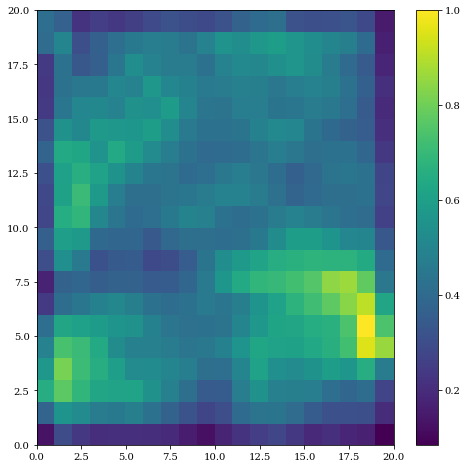

In [10]:
plt.figure(figsize=(8, 8))

plt.pcolor(som.distance_map(), cmap='viridis')  # plotting the distance map as background

plt.colorbar()

plt.show()

# what is being shown here? 

In [11]:
win_map = som.win_map(c_gen_data, return_indices = True) # returns a dictionary with all indices of the elements 
                                                         # that have been mapped to the position (i,j) 

In [12]:
# create empty "map" to hold mean z true 
mean_z_map = np.zeros(som.distance_map().shape)
#print(mean_z_map)

for iy, ix in np.ndindex(mean_z_map.shape): 
    #print(mean_z_map[iy, ix]) 
    mean_z_map[iy, ix] = np.mean(c_gen[win_map[(iy, ix)]]['ztrue'])

/Users/diana/Library/Python/3.8/lib/python/site-packages/numpy/core/fromnumeric.py:3438: RuntimeWarning: Mean of empty slice.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/Users/diana/Library/Python/3.8/lib/python/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


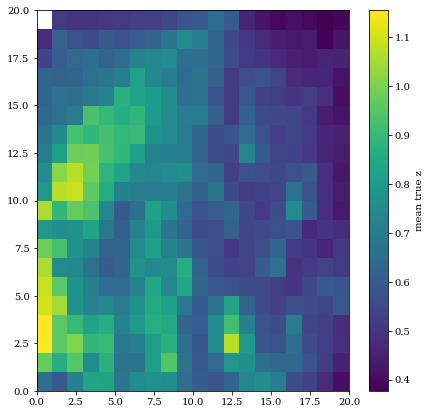

In [13]:
plt.figure(figsize=(7, 7))

plt.pcolor(mean_z_map, cmap='viridis')  # plotting the mean true zs in each tomographic bin

cbar = plt.colorbar()
cbar.set_label('mean true z') 

# what is being shown here? (in a physical sense :)

In [14]:
# now, rather than using the magnitudes, repeat the same procedure using the galaxy 
# "colors" rather than the magnitudes!